In [1]:
import copy
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from pre_processing import *
from algorithms import *
from spectrum_gen import *
from data_gen import *
from analysis import *
from datasets import *
from evaluation import *
#cr_filtering()
#cr_read_norm()1dasdas
import h5py
import scanpy as sc
from sklearn.metrics import adjusted_rand_score
n_obs=1000 #number of observations per timepoint


In [2]:
adata = read_liver_data_2(n_obs=n_obs) #read data
adata = sort_data_crit(adata=copy.deepcopy(adata.copy()),crit='ZT',crit_list=['0','6','12','18']) #sort the data according to the timepoints
adata

/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/jonathankarin/.conda/envs/spctral_jan/l

View of AnnData object with n_obs × n_vars = 4000 × 14812
    obs: 'ZT', 'layer', 'batch'

In [3]:
#standard pre-processing
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.filter_genes_dispersion(adata, n_top_genes=7000)
orig_adata = copy.deepcopy(adata.copy())



/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


         Falling back to preprocessing with `sc.pp.pca` and default params.


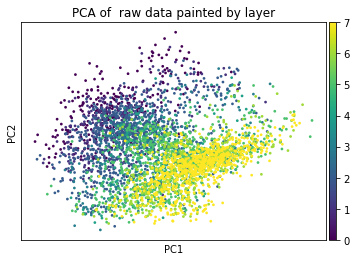

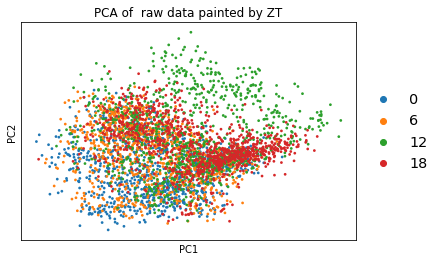

/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


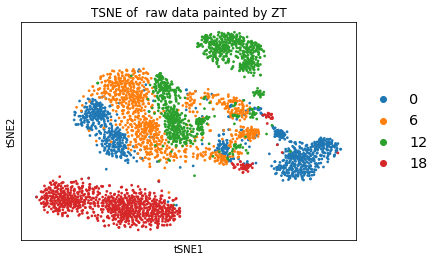

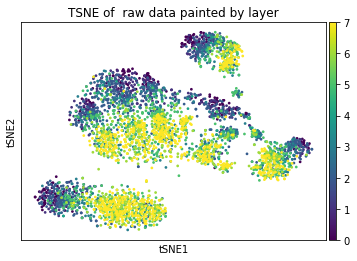

In [4]:
plots_liver(adata,title=" raw data")


7000
1


/Users/jonathankarin/PycharmProjects/scPrisma_rev/algorithms.py:628: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  tmp_value, grad = fAndG_full(A=A, B=F, V=V, alpha=regu, regu_norm=regu_norm)
/Users/jonathankarin/PycharmProjects/scPrisma_rev/algorithms.py:628: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  tmp_value, grad = fAndG_full(A=A, B=F, V=V, alpha=regu, regu_norm=regu_norm)
/Users/jonathankarin/PycharmProjects/scPrisma_rev/algorithms.py:628: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  tmp_value, grad = fAndG_full(A=A, B=F, V=V, alpha=regu, regu_norm=regu_norm)


(4000, 7000)
(4000, 7000)
(4000, 3999)
Iteration number: 1
         Falling back to preprocessing with `sc.pp.pca` and default params.


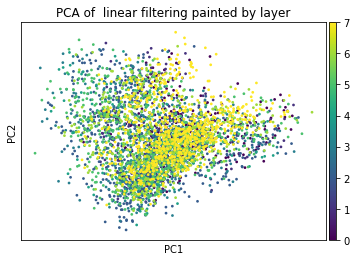

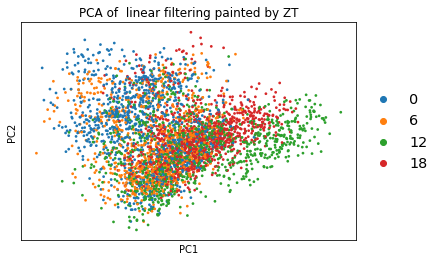

/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


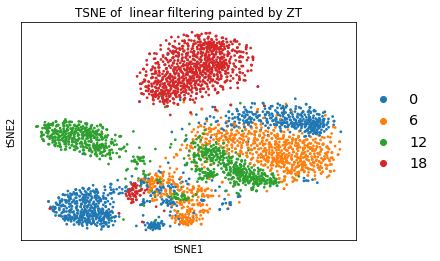

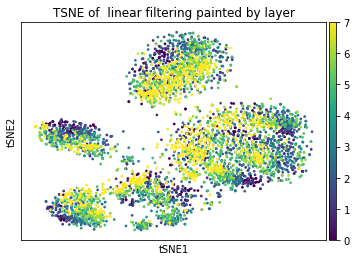

Norm change: 395.6211951732542


In [5]:
#linear filtering
linear_adata = copy.deepcopy(orig_adata.copy())
linear_adata = shuffle_adata(linear_adata)
linear_adata = sort_data_linear(linear_adata)
adata_linear_filtered = copy.deepcopy(linear_adata.copy())
F1 = filter_linear_full(adata_linear_filtered.X, regu=0.1 , regu_norm='L1' , iterNum=100 , method= 'numeric')
adata_linear_filtered.X = adata_linear_filtered.X * F1
plots_liver(adata_linear_filtered,title=" linear filtering")
print("Norm change: " +str(np.linalg.norm(linear_adata.X-adata_linear_filtered.X)))


starting filtering
25
th Iteration    Loss :: 
2208.325564515792
50
th Iteration    Loss :: 
1116.0590074772856
75
th Iteration    Loss :: 
798.4040025138897
100
th Iteration    Loss :: 
592.3962822170658
125
th Iteration    Loss :: 
514.8135727586147
150
th Iteration    Loss :: 
407.466551996773
175
th Iteration    Loss :: 
360.00478486511685
200
th Iteration    Loss :: 
328.43808337723254
225
th Iteration    Loss :: 
288.1755167419464
250
th Iteration    Loss :: 
261.93326913461516
275
th Iteration    Loss :: 
243.78530394562657
300
th Iteration    Loss :: 
232.15421902539657
         Falling back to preprocessing with `sc.pp.pca` and default params.


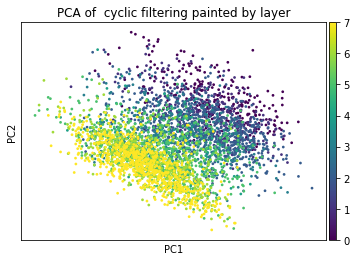

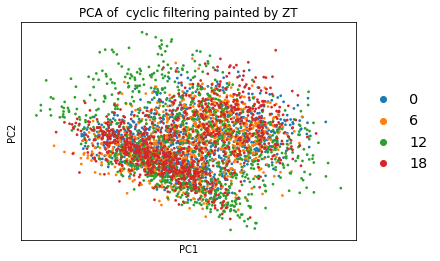

/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


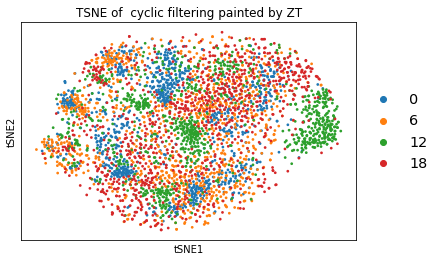

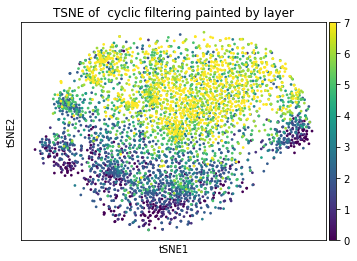

Norm change: 705.4886232465091


In [6]:
#cyclic filtering

adata_cyclic_filtered = copy.deepcopy(orig_adata.copy())
F = filtering_cyclic(adata_cyclic_filtered.X, regu=0, iterNum=300, verbosity=25)
adata_cyclic_filtered.X = adata_cyclic_filtered.X * F
plots_liver(adata_cyclic_filtered,title=" cyclic filtering")
print("Norm change: " +str(np.linalg.norm(orig_adata.X-adata_cyclic_filtered.X)))


25
th Iteration    Loss :: 
1892.9921069690788
 gradient :: 
21.752970538556955
Iteration number: 
1
function value: 
38747.21860471808
Iteration number: 
26
function value: 
267841.25664399867
Iteration number: 
51
function value: 
290813.7394596094
Iteration number: 
76
function value: 
298090.4081156428
         Falling back to preprocessing with `sc.pp.pca` and default params.


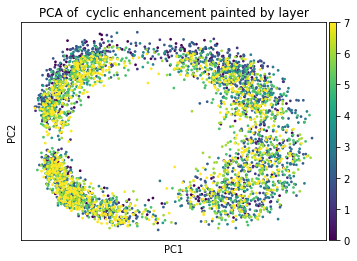

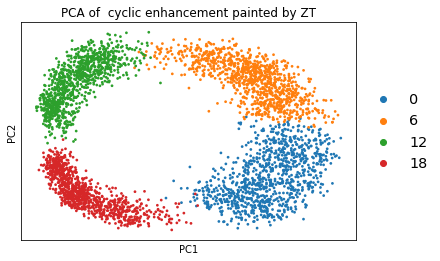

/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


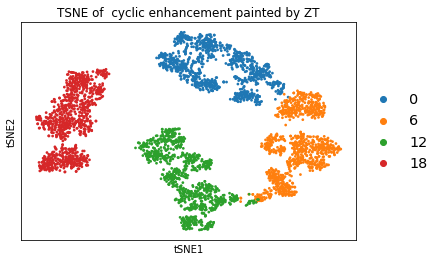

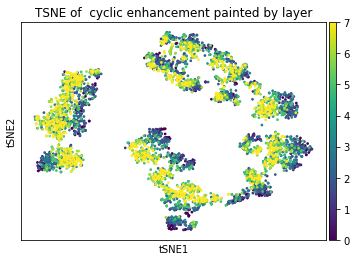

Norm change: 2110.7990182852905


In [7]:
#cyclic enhancement
adata_cyclic_enhancment = copy.deepcopy(orig_adata.copy())
D = filter_non_cyclic_genes_line((np.array(adata_cyclic_enhancment.X)).astype('float64'), regu=1,iterNum=25)
adata_cyclic_enhancment.X = adata_cyclic_enhancment.X.dot(D)
F =enhancement_cyclic((np.array(adata_cyclic_enhancment.X)).astype('float64'), regu=0.01 ,iterNum=100)
adata_cyclic_enhancment.X = adata_cyclic_enhancment.X * F
plots_liver(adata_cyclic_enhancment,title=" cyclic enhancement")
print("Norm change: " +str(np.linalg.norm(orig_adata.X-adata_cyclic_enhancment.X)))


/Users/jonathankarin/PycharmProjects/scPrisma_rev/algorithms.py:389: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, F), array(float64, 2d, A))
  ATUUTA = (2 * ((((A.T).dot(U)).dot(U.T)).dot(A)))


25
th Iteration    Loss :: 
1848.1409251100329
 gradient :: 
17.076939119363935
50
th Iteration    Loss :: 
1846.6021524657158
 gradient :: 
17.07549317067062


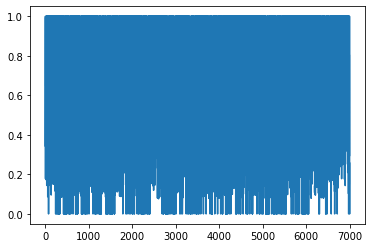

Iteration number: 
1
function value: 
43143.40923314456
         Falling back to preprocessing with `sc.pp.pca` and default params.


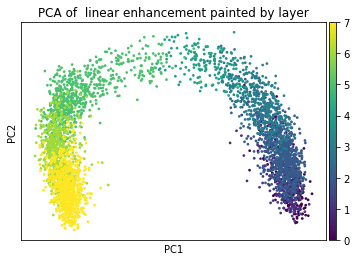

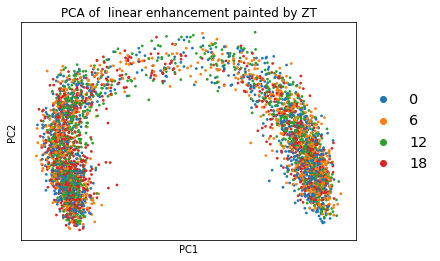

/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


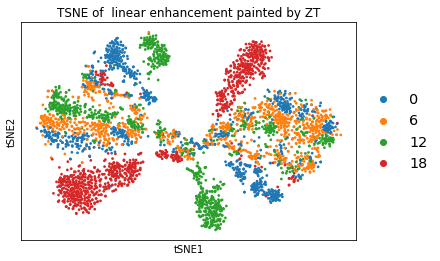

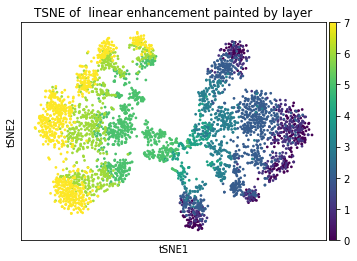

Norm change: 1362.5977525966944


In [8]:
#linear enhancement

adata_linear_enhanced = linear_adata.copy()

D = filter_linear_genes_line((np.array(adata_linear_enhanced.X)).astype('float64'),regu=1,method='numeric' , iterNum=50) #0.5
D1 = np.identity(D.shape[0])-D
plt.plot(range(7000),D.diagonal())
plt.show()

adata_linear_enhanced.X = adata_linear_enhanced.X.dot(D1)
F_en = enhancement_linear((np.array(adata_linear_enhanced.X)).astype('float64'), regu=-0.05, iterNum=10 , method='numeric') # -0.01
adata_linear_enhanced.X = adata_linear_enhanced.X * F_en
plots_liver(adata_linear_enhanced,title=" linear enhancement")
print("Norm change: " +str(np.linalg.norm(linear_adata.X-adata_linear_enhanced.X)))


25
th Iteration    Loss :: 
1907.9749655206315
 gradient :: 
18.12206993398186
50
th Iteration    Loss :: 
1905.436421187049
 gradient :: 
18.11718878828639


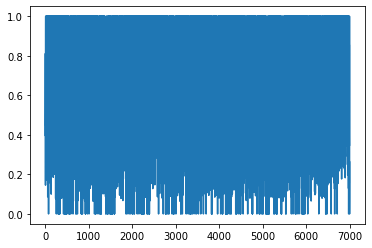

Iteration number: 
1
function value: 
37181.020161339


/Users/jonathankarin/PycharmProjects/scPrisma_rev/visualizations.py:523: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  sc.pp.neighbors(adata)


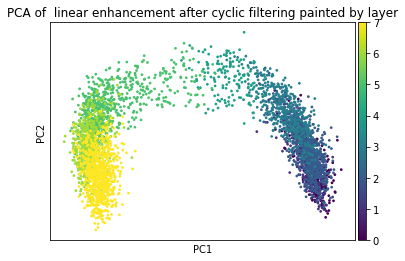

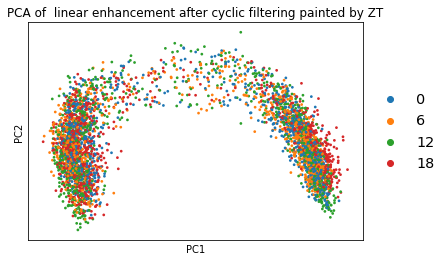

/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


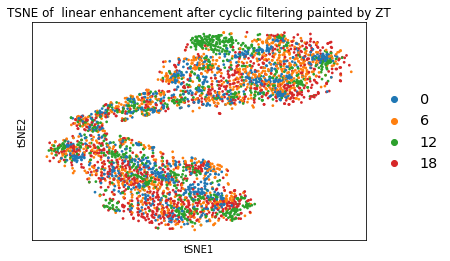

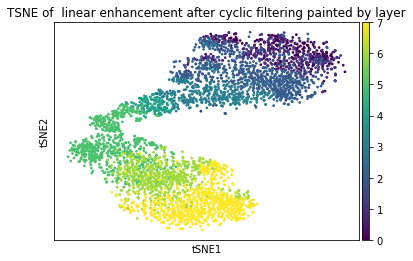

In [9]:
adata_cyclic_filtered_for_linear = copy.deepcopy(adata_cyclic_filtered.copy())
adata_cyclic_filtered_for_linear = sort_data_linear(adata_cyclic_filtered_for_linear)

D = filter_linear_genes_line((np.array(adata_cyclic_filtered_for_linear.X)).astype('float64'),regu=1,method='numeric' , iterNum=50) #0.5
D1 = np.identity(D.shape[0])-D
plt.plot(range(7000),D.diagonal())
plt.show()

adata_cyclic_filtered_for_linear.X = adata_cyclic_filtered_for_linear.X.dot(D1)
F_en = enhancement_linear((np.array(adata_cyclic_filtered_for_linear.X)).astype('float64'), regu=-0.05, iterNum=10 , method='numeric') # -0.01
adata_cyclic_filtered_for_linear.X = adata_cyclic_filtered_for_linear.X * F_en
plots_liver(adata_cyclic_filtered_for_linear,title=" linear enhancement after cyclic filtering")


25
th Iteration    Loss :: 
1904.065329995199
 gradient :: 
21.363564005951503
Iteration number: 
1
function value: 
37345.31463648087
Iteration number: 
26
function value: 
261280.05505219108
Iteration number: 
51
function value: 
284089.8705274018
Iteration number: 
76
function value: 
291701.0406827306


/Users/jonathankarin/PycharmProjects/scPrisma_rev/visualizations.py:523: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  sc.pp.neighbors(adata)


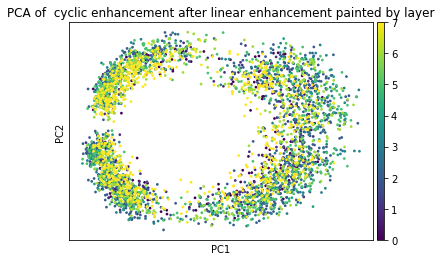

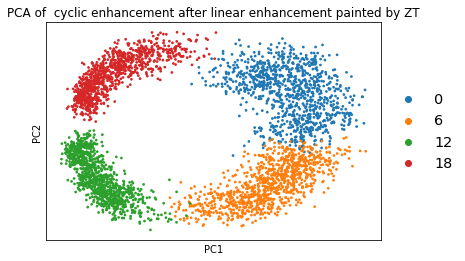

/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


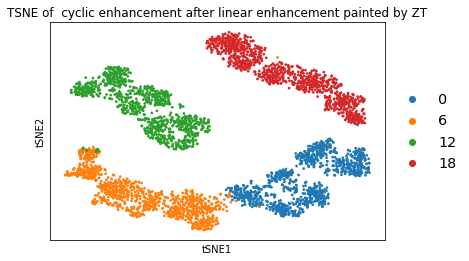

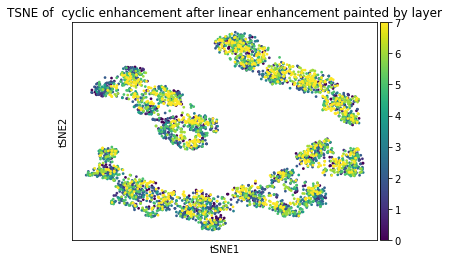

In [10]:

adata_linear_filtered_for_cyclic = copy.deepcopy(adata_linear_filtered.copy())
adata_linear_filtered_for_cyclic = sort_data_crit(adata=copy.deepcopy(adata_linear_filtered_for_cyclic.copy()),crit='ZT',crit_list=['0','6','12','18']) #sort the data according to the timepoints
D = filter_non_cyclic_genes_line((np.array(adata_linear_filtered_for_cyclic.X)).astype('float64'), regu=1,iterNum=25)
adata_linear_filtered_for_cyclic.X = adata_linear_filtered_for_cyclic.X.dot(D) 
F =enhancement_cyclic((np.array(adata_linear_filtered_for_cyclic.X)).astype('float64'), regu=0.01 ,iterNum=100)
adata_linear_filtered_for_cyclic.X = adata_linear_filtered_for_cyclic.X * F
plots_liver(adata_linear_filtered_for_cyclic,title=" cyclic enhancement after linear enhancement")
